In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from k_means import *

### Data loading

In [3]:
root = "/media/dikra/PhD/DATA/DLC24_Data/tiny_all_bird_merged_coco"
images = f"{root}/images"
annotations = f"{root}/annotations"

In [4]:
train_file = open(f"{annotations}/train.json")
test_file = open(f"{annotations}/test.json")
train_data = json.load(train_file)
test_data = json.load(test_file)

In [5]:
train_ann = len(train_data["annotations"])
f"{train_ann} Annotated train images"

'414 Annotated train images'

In [6]:
cats = train_data["categories"][0]["keypoints"]
cats_dict = dict(zip(range(0, len(cats)), cats))
cats_dict

{0: 'back',
 1: 'bill',
 2: 'belly',
 3: 'breast',
 4: 'crown',
 5: 'forehead',
 6: 'left_eye',
 7: 'left_leg',
 8: 'left_wing_tip',
 9: 'left_wrist',
 10: 'nape',
 11: 'right_eye',
 12: 'right_leg',
 13: 'right_wing_tip',
 14: 'right_wrist',
 15: 'tail_tip',
 16: 'throat',
 17: 'neck',
 18: 'tail_left',
 19: 'tail_right',
 20: 'upper_spine',
 21: 'upper_half_spine',
 22: 'lower_half_spine',
 23: 'right_foot',
 24: 'left_foot',
 25: 'left_half_chest',
 26: 'right_half_chest',
 27: 'chin',
 28: 'left_tibia',
 29: 'right_tibia',
 30: 'lower_spine',
 31: 'upper_half_neck',
 32: 'lower_half_neck',
 33: 'left_chest',
 34: 'right_chest',
 35: 'upper_neck',
 36: 'left_wing_shoulder',
 37: 'left_wing_elbow',
 38: 'right_wing_shoulder',
 39: 'right_wing_elbow',
 40: 'upper_cere',
 41: 'lower_cere'}

### Data prep

In [7]:
all_keypoints = get_all_keypoints(train_data)  # load all keypoint annotations
parsed_keypoints = keypoint2triple(
    all_keypoints
)  # parse keypoint annotations into (x, y, visibility) triples
indexed_keypoints = get_keypoints_dict(
    parsed_keypoints
)  # index keypoint with corresponding body part
visible_keypoints = get_visible_keypoints(
    indexed_keypoints
)  # filter out invisible & occluded keypoints (keeping 1. and 2. visibility)
features = get_features(
    visible_keypoints
)  # turn dict into pandas dataframe for kmeans & visualisation manipulations
f"{len(features)} visible annotated keypoints"

'1951 visible annotated keypoints'

In [8]:
gt_labels = [
    list(i.keys()) for i in visible_keypoints
]  # ground truth bodypart labels of the keypoint
gt_labels = sum(gt_labels, [])
len(gt_labels), np.unique(gt_labels)

(1951, array([ 1,  6,  8,  9, 10, 11, 13, 14, 15, 17, 23, 24]))

In [10]:
ground_truth = to_df(features, gt_labels)
ground_truth.sample(10)

,0,1,label
15,516.0,50.0,15
9,293.0,355.0,9
14,1283.0,480.0,14
15,744.0,330.0,15
9,380.0,324.0,9
9,1117.0,323.0,9
1,954.0,985.0,1
23,436.0,40.0,23
13,538.0,77.0,13
1,283.0,367.0,1


### KMeans clustering

In [15]:
n_clusters = 3 # len(cats)

scaled_features, centers, predicted_labels = keypoint_kmeans(n_clusters, features)

In [16]:
# Construct dataframe from predicted clusters
predicted_clusters = to_df(scaled_features, predicted_labels)
predicted_clusters.sample(10)

,0,1,label
0,-0.287158,-0.339156,0
0,-1.659955,-0.285999,0
0,-0.534674,-0.798812,0
2,0.576856,-0.404821,2
0,-0.685934,-1.014568,0
2,0.187247,-0.479867,2
1,-0.126731,1.605780,1
0,-1.458275,-0.279745,0
0,-0.248197,-0.339156,0
0,-1.029706,0.849068,0


Text(0.5, 1.0, 'Train keypoints: 3 clusters')

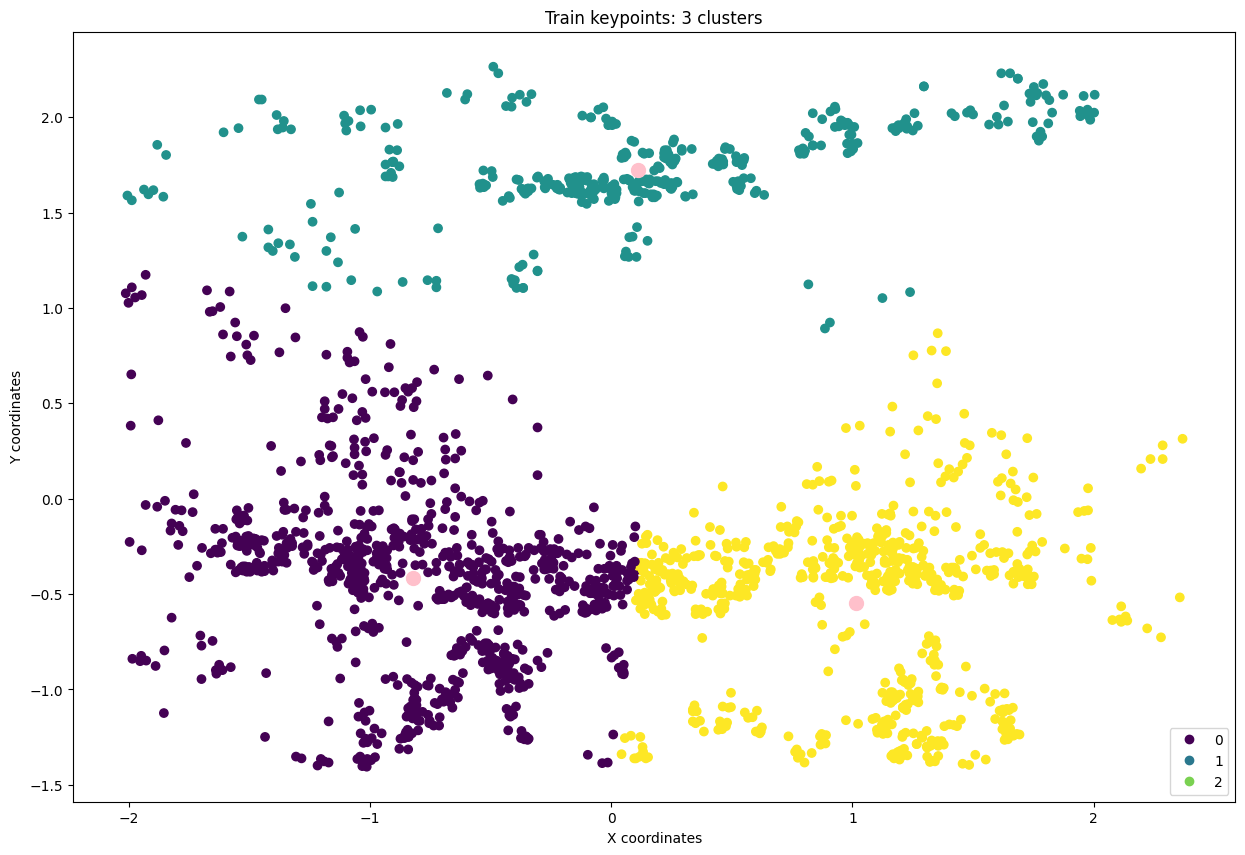

In [17]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(
    predicted_clusters[0], predicted_clusters[1], c=predicted_clusters["label"]
)
scatter2 = plt.scatter(centers[:, 0], centers[:, 1], c="pink", s=100)
plt.xlabel("X coordinates")
plt.ylabel("Y coordinates")

unique_labels = np.unique(predicted_clusters["label"])
handles, labels = scatter.legend_elements(prop="colors", num=len(unique_labels))
plt.legend(
    handles, unique_labels, loc="lower right", ncol=len(unique_labels) / n_clusters
)
plt.title(f"Train keypoints: {n_clusters} clusters")

Text(0.5, 1.0, 'Ground Truth Train Keypoints')

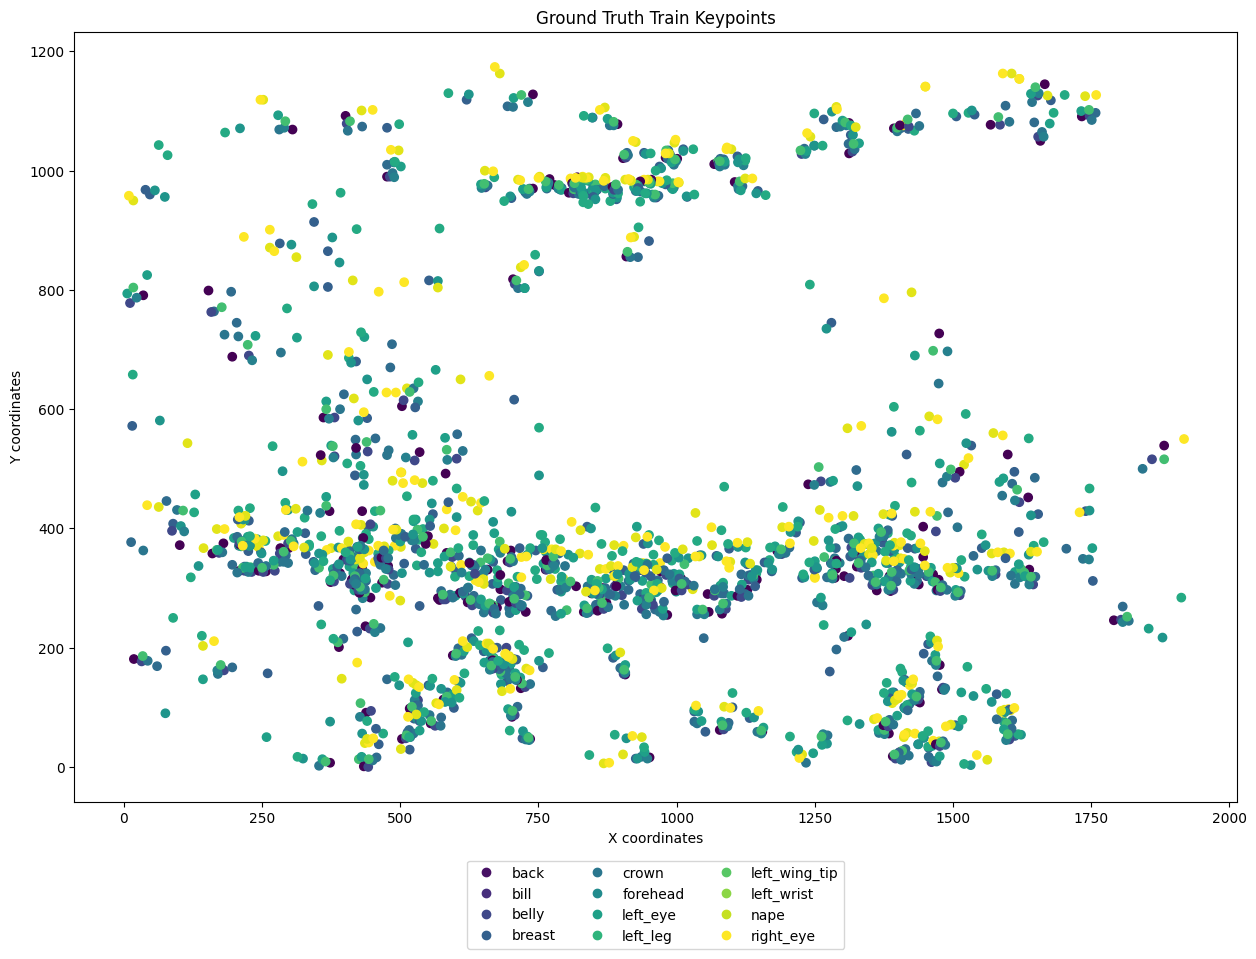

In [18]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(ground_truth[0], ground_truth[1], c=ground_truth["label"])
# scatter2 = plt.scatter(centers[:, 0], centers[:, 1], c="pink", s=100)
plt.xlabel("X coordinates")
plt.ylabel("Y coordinates")

unique_labels = np.unique(ground_truth["label"])
handles, labels = scatter.legend_elements(prop="colors", num=len(unique_labels))
plt.legend(
    handles,
    cats,
    loc="lower center",
    ncol=len(unique_labels) / 4,
    bbox_to_anchor=(0.5, -0.2),
)
plt.title(f"Ground Truth Train Keypoints")